rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|
it: 0
it: 2000
it: 4000
it: 6000
it: 8000


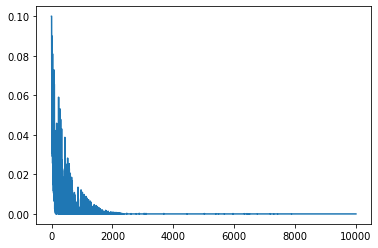

update counts:
---------------------------
 0.15| 0.15| 0.17| 0.00|
---------------------------
 0.15| 0.00| 0.06| 0.00|
---------------------------
 0.19| 0.06| 0.06| 0.01|
values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00| 0.80| 0.00|
---------------------------
 0.31| 0.46| 0.62| 0.46|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |


In [1]:
# https://deeplearningcourses.com/c/artificial-intelligence-reinforcement-learning-in-python
# https://www.udemy.com/artificial-intelligence-reinforcement-learning-in-python
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np
import matplotlib.pyplot as plt
from grid_world import standard_grid, negative_grid
from iterative_policy_evaluation import print_values, print_policy
from monte_carlo_es import max_dict
from td0_prediction import random_action

GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')


if __name__ == '__main__':
  # NOTE: if we use the standard grid, there's a good chance we will end up with
  # suboptimal policies
  # e.g.
  # ---------------------------
  #   R  |   R  |   R  |      |
  # ---------------------------
  #   R* |      |   U  |      |
  # ---------------------------
  #   U  |   R  |   U  |   L  |
  # since going R at (1,0) (shown with a *) incurs no cost, it's OK to keep doing that.
  # we'll either end up staying in the same spot, or back to the start (2,0), at which
  # point we whould then just go back up, or at (0,0), at which point we can continue
  # on right.
  # instead, let's penalize each movement so the agent will find a shorter route.
  #
  # grid = standard_grid()
  grid = negative_grid(step_cost=-0.1)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # no policy initialization, we will derive our policy from most recent Q

  # initialize Q(s,a)
  Q = {}
  states = grid.all_states()
  for s in states:
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      Q[s][a] = 0

  # let's also keep track of how many times Q[s] has been updated
  update_counts = {}
  update_counts_sa = {}
  for s in states:
    update_counts_sa[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
      update_counts_sa[s][a] = 1.0

  # repeat until convergence
  t = 1.0
  deltas = []
  for it in range(10000):
    if it % 100 == 0:
      t += 1e-2
    if it % 2000 == 0:
      print("it:", it)

    # instead of 'generating' an epsiode, we will PLAY
    # an episode within this loop
    s = (2, 0) # start state
    grid.set_state(s)

    # the first (s, r) tuple is the state we start in and 0
    # (since we don't get a reward) for simply starting the game
    # the last (s, r) tuple is the terminal state and the final reward
    # the value for the terminal state is by definition 0, so we don't
    # care about updating it.
    a, _ = max_dict(Q[s])
    biggest_change = 0
    while not grid.game_over():
      a = random_action(a, eps=0.5/t) # epsilon-greedy
      # random action also works, but slower since you can bump into walls
      # a = np.random.choice(ALL_POSSIBLE_ACTIONS)
      r = grid.move(a)
      s2 = grid.current_state()
    
    
      # adaptive learning rate 
    
      alpha = ALPHA / update_counts_sa[s][a]
      update_counts_sa[s][a] += 0.005

      # we will update Q(s,a) AS we experience the episode
      old_qsa = Q[s][a]
      # the difference between SARSA and Q-Learning is with Q-Learning
      # we will use this max[a']{ Q(s',a')} in our update
      # even if we do not end up taking this action in the next step
      a2, max_q_s2a2 = max_dict(Q[s2])
      Q[s][a] = Q[s][a] + ALPHA*(r + GAMMA*max_q_s2a2 - Q[s][a])
      biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

      # we would like to know how often Q(s) has been updated too
      update_counts[s] = update_counts.get(s,0) + 1

      # next state becomes current state
      s = s2
      a = a2
     
    deltas.append(biggest_change)

  plt.plot(deltas)
  plt.show()

  # determine the policy from Q*
  # find V* from Q*
  policy = {}
  V = {}
  for s in grid.actions.keys():
    a, max_q = max_dict(Q[s])
    policy[s] = a
    V[s] = max_q

  # what's the proportion of time we spend updating each part of Q?
  print("update counts:")
  total = np.sum(list(update_counts.values()))
  for k, v in update_counts.items():
    update_counts[k] = float(v) / total
  print_values(update_counts, grid)

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)


